# Module 3: Machine Learning

## Sprint 2: Intermediate Machine Learning

## House prices regression competition, part 2

---

## Requirements

- Build and submit a scikit-learn pipeline having neural network regressor as the model
- Build and submit a scikit-learn pipeline having gradient boosted regressor as the model
- Build and submit a xgboost model
- Achieve a score better than 0.13 on the public leaderboard

## Evaluation criteria

- Public leaderboard score
- How simple is the model
- How fast is the model prediction
- Code quality


## Sample correction questions

During a correction, you may get asked questions that test your understanding of covered topics.

- How can model regularization help and what are some of the ways to use regularization?
- What are the benefits and the risks of hyper-parameter optimization?
- Why is it useful to crossvalidate your model using many splits? Why sometimes a single validation split is still used?
- Why is it useful to build a pipeline that encapsulates all the preprocessing, model training and other steps?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

import time
import warnings
warnings.filterwarnings('ignore')
SEED = 42


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def concat_df(train_data,test_data):
  """Function to concatenate 2 dataframes"""
  return pd.concat([train_data,test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
  """Function to split the 2 dataframes"""
  return all_data.loc[:1459], all_data.loc[1460:]

In [3]:
df_train = pd.read_csv("train.csv")
y_train = df_train.SalePrice
id_val = df_train.Id
print(f"Train data shape is:", df_train.shape )
df_test = pd.read_csv("test.csv")
print(f"Test data shape is:", df_test.shape )

Train data shape is: (1460, 81)
Test data shape is: (1459, 80)


In [4]:
df_all = concat_df(df_train,df_test).drop(["SalePrice","Id"],axis=1)
df_train.name = "Train"
df_test.name = "Test"
df_all.name = "All"
dataframes = [df_train,df_test]
print("DataFrame joined")

DataFrame joined


### Missing Values

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = ((df_train.isnull().sum()/df_train.isnull().count()) * 100).sort_values(ascending=False)
missing_values = pd.concat([total,percent], axis=1, keys = ["total","percent"])
print("Sorted missing values in descending order:")
missing_values.head(20)

Sorted missing values in descending order:


,total,percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


* For features with missing values less than 100 - fill numeric with median, categoricals with mode.
* For features with missing values > 1000 - Drop this features
* For other features - Fill with null

In [6]:
null_feat = df_all.isnull().sum()

# For features with missing values less than 100
null_100 = df_all.columns[list((null_feat<100) & (null_feat != 0))]
numerical_null_100 = df_all[null_100].select_dtypes(include=np.number).columns
categorical_null_100 = df_all[null_100].select_dtypes(include="object").columns

# Apply fill with median to numericals
df_all[numerical_null_100] = df_all[numerical_null_100].apply(lambda x: x.fillna(x.median()))

# Apply fill with mode to categoricals
df_all[categorical_null_100] = df_all[categorical_null_100].apply(lambda x: x.fillna(x.value_counts().index[0]))

# For features having larger than 1000
null_1000 = df_all.columns[list(null_feat>1000)]
df_all.drop(null_1000, axis=1, inplace=True)
df_all.drop(["GarageYrBlt","LotFrontage"], axis=1, inplace=True)

# Fill with "Null" for other values
df_all["GarageCond"] = df_all["GarageCond"].fillna("Null")
df_all["GarageFinish"] = df_all["GarageFinish"].fillna("Null")
df_all["GarageQual"] = df_all["GarageQual"].fillna("Null")
df_all["GarageType"] = df_all["GarageType"].fillna("Null")

In [7]:
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)
print(f"Sum of null values in dataset after filling:", df_all.isnull().any().sum())

Sum of null values in dataset after filling: 0


### Categorical Features

* Some columns in the training set do not exist in the test set. Visualizing some categorical features shows their variation with the target feature.
* There are 38 categorical features in the dataset

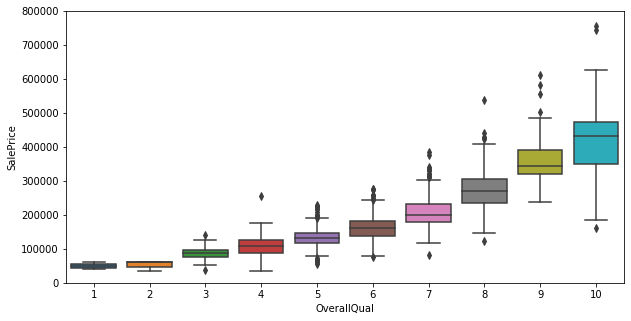

In [8]:
#OverallQuall
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=df_train["OverallQual"],y=df_train["SalePrice"])
fig.axis(ymin=0, ymax=800000);

`OverallQuall` shows increase in `SalePrice` as the quality increases.

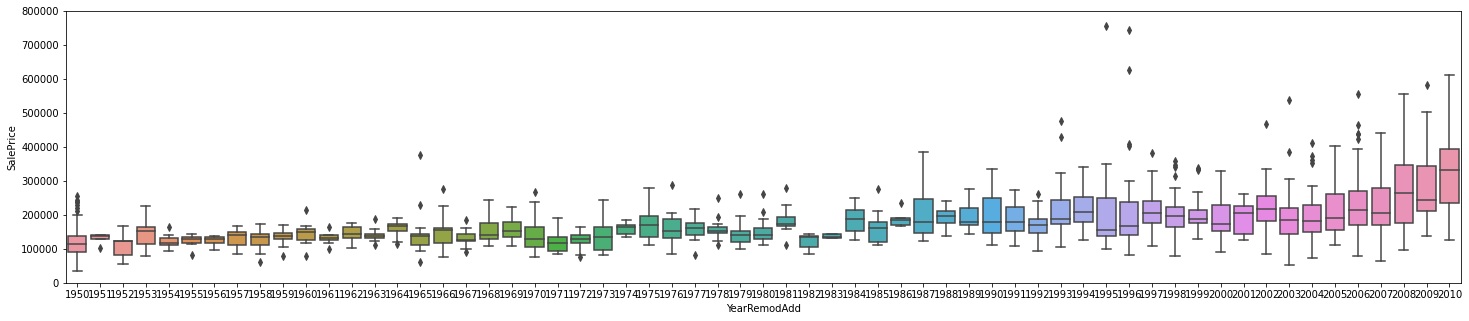

In [9]:
#YearRemodAdd
f, ax = plt.subplots(figsize=(25, 5))
fig = sns.boxplot(x=df_train["YearRemodAdd"],y=df_train["SalePrice"])
fig.axis(ymin=0, ymax=800000);

`YearRemodAdd` shows variability but other factors could have constituted in the increase in proce for that year. This alone can not be considered.

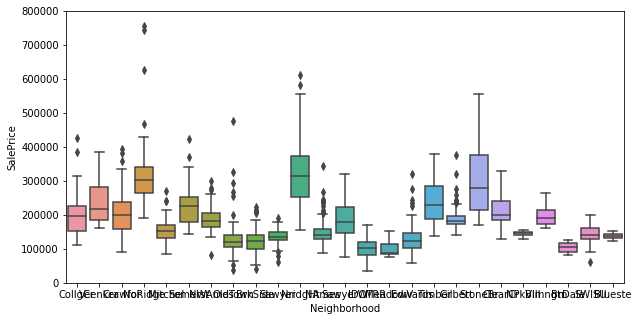

In [10]:
#Neighborhood
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=df_train["Neighborhood"],y=df_train["SalePrice"])
fig.axis(ymin=0, ymax=800000);

`Neighborhood` also shows variability with price. 

(-0.5, 1.5, 0.0, 800000.0)

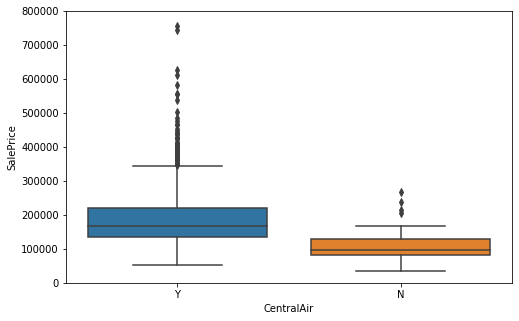

In [11]:
#CentralAir
f, ax = plt.subplots(figsize=(8, 5))
fig = sns.boxplot(x=df_train["CentralAir"],y=df_train["SalePrice"])
fig.axis(ymin=0, ymax=800000)

`CentralAir` does not distinguish more but it can be seen that high prices are within the `Yes`

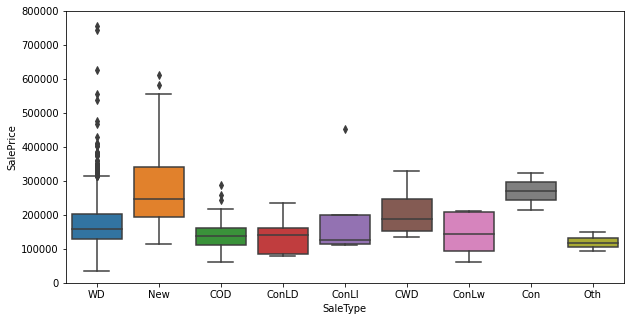

In [12]:
#Saletype
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=df_train["SaleType"],y=df_train["SalePrice"])
fig.axis(ymin=0, ymax=800000);

`Saletype` shows some good variability. Rename for better understanding 

### Numerical Features

* There are 34 numeric features in the dataset
* Carried out a variable investigation to determing which variables have high, low or medium expectations.This is based on what I will personally look for in a house.

In [13]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

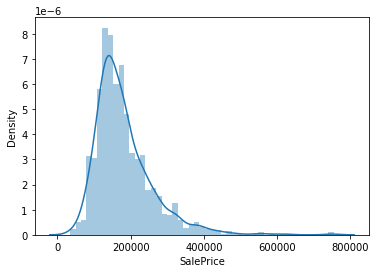

In [14]:
sns.distplot(df_train["SalePrice"]);

In [15]:
# skewness and kurtosis
# https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The minimum `SalePrice` seem reasonable. The distribution is not normal and also it is right skewed (mean > median > mode), i.e. It has a higher number of datapoints having low values, so when we train our model like this, it will perform better at predicting low house prices. Skewness also tells us about the direction of outliers
https://www.analyticsvidhya.com/blog/2020/07/what-is-skewness-statistics/

The Kurtosis is Leptokurtic (i.e Kurtosis > 3). This shows from the viz,the sistribution is peaked and possesses thick tails.

Text(0, 0.5, 'House sale price')

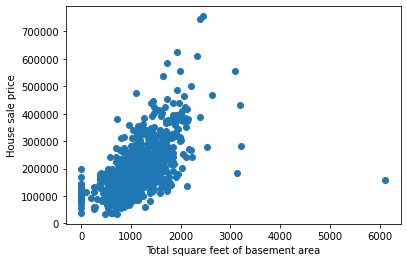

In [16]:
plt.scatter(df_train["TotalBsmtSF"],df_train["SalePrice"]);
plt.xlabel("Total square feet of basement area")
plt.ylabel("House sale price")

`TotalBsmtSF` seem to make price increase as it increases. Some data points look like outliers

Text(0, 0.5, 'House sale price')

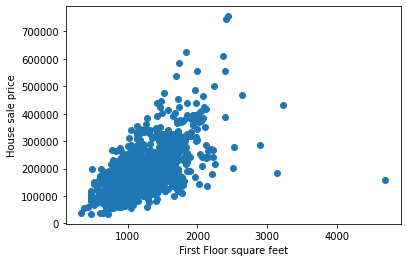

In [17]:
plt.scatter(df_train["1stFlrSF"],df_train["SalePrice"]);
plt.xlabel("First Floor square feet")
plt.ylabel("House sale price")

`1stFlrSF` seem to make price increase as it increases. Some data points look like outliers

Text(0, 0.5, 'House sale price')

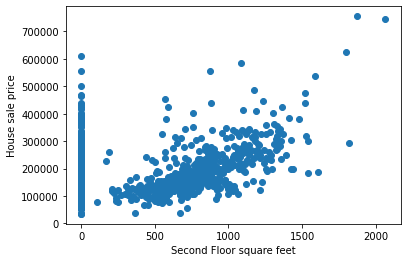

In [18]:
plt.scatter(df_train["2ndFlrSF"],df_train["SalePrice"]);
plt.xlabel("Second Floor square feet")
plt.ylabel("House sale price")

`2ndFlrSF` does not look like a predominant factor of price increase. 

Text(0, 0.5, 'House sale price')

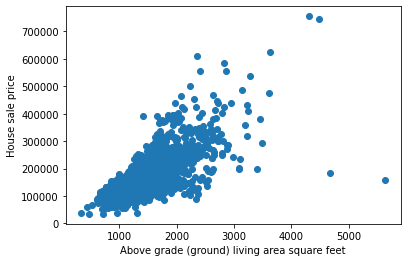

In [19]:
plt.scatter(df_train["GrLivArea"],df_train["SalePrice"]);
plt.xlabel("Above grade (ground) living area square feet")
plt.ylabel("House sale price")

Text(0, 0.5, 'House sale price')

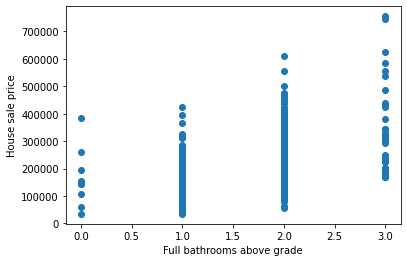

In [20]:
plt.scatter(df_train["FullBath"],df_train["SalePrice"]);
plt.xlabel("Full bathrooms above grade")
plt.ylabel("House sale price")

`GrLivArea` does increases the sale price. Houses with `FullBath` of 2 or more do not start at lowe rprices

`OverallQuall` is a already being viewed as a categorical feature

## Feature Engineering

* Binning all features representing Year
* Then encode them into continous feature

Transform target feature from heavy tailed to normal distribution using Box-Cox transformation.
https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203

In [21]:
y_train = pd.Series(stats.boxcox(y_train, lmbda=0), name="SalePrice")
y_train_copy = y_train.copy()


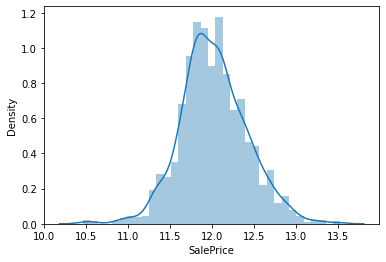

In [22]:
# Confirm transformation with normal probability plot
sns.distplot(y_train);

In [23]:
# Binning the years
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop') #Quantile based discretization function
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

In [24]:
# Encode categorical to numeric features
for cats in ["YearBuilt", "YearRemodAdd", "YrSold"]:
  df_all[cats] = preprocessing.LabelEncoder().fit_transform(df_all[cats].values)

In [25]:
# Transform some numeric to categorical features
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

#### Generate new features

In [26]:
df_all["TotalSqFt"] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']
df_all["TotalBath"] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) + df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
df_all["TotalBasementBath"] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])
df_all["TotalPorchSqFt"] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])
# Drop all features generated from
remove_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath',
              'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
df_all.drop(remove_cols, axis=1, inplace=True)

In [27]:
# Check existence of some features
df_all['IsRemodel'] = df_all[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 1 if x[0] != x[1] else 0, axis=1)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
# List of categorical features
cat_features = list(df_all.select_dtypes(include=['object', 'category']).columns)

# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_all.select_dtypes(include=numeric_dtypes).columns)

In [29]:
# Update training and testing dataset
df_train, df_test = divide_df(df_all)

In [30]:
print(cat_features)

['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


#### Mismatched features

In [31]:
cat_mismatch = list()
for cat_col in cat_features:
    train_cat = df_train[cat_col].value_counts().index
    test_cat = df_test[cat_col].value_counts().index
    check_len = len(np.setdiff1d(train_cat, test_cat)) + len(np.setdiff1d(test_cat, train_cat))
    if check_len != 0:
        cat_mismatch.append(cat_col)
        
print('List of mismatched value features: \n', cat_mismatch)

List of mismatched value features: 
 ['Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'GarageQual', 'Heating', 'HouseStyle', 'MSSubClass', 'RoofMatl', 'Utilities']


In [32]:
df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'
df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'
df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'
df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'
df_test['MSSubClass'].loc[df_test['MSSubClass']=='150'] = '160'
print("Mismatched replaced successfully")

temp = [True if ((val=='RRNn') | (val=='RRAn') | (val=='RRAe')) else False
        for val in df_train['Condition2']]
df_train['Condition2'].loc[temp] = 'Norm'

cate_drop = ['Utilities', 'RoofMatl']
df_train.drop(cate_drop, axis=1, inplace=True)
df_test.drop(cate_drop, axis=1, inplace=True)

cat_features = [col for col in cat_features if col not in cate_drop]
print(cat_features)

Mismatched replaced successfully
['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street']


## Feature Selection

#### Categorical Features

In [33]:
def forward_feature_selection(df_train, cat_features):
  """Function to perform forward feature selection on all categorical features"""
  df_ffs = pd.DataFrame(columns=cat_features)
  for cat_col in cat_features:
    df_ffs[cat_col] = preprocessing.LabelEncoder().fit_transform(df_train[cat_col].values)

  ffs = SequentialFeatureSelector(RandomForestRegressor(), k_features="best", forward=True, n_jobs=-1)
  ffs_fit = ffs.fit(np.array(df_ffs[cat_features]), np.array(y_train))
  return ffs_fit


ffs_fit = forward_feature_selection(df_train, cat_features)
cat_features = list(df_all[cat_features].columns[list(ffs_fit.k_feature_idx_)])
print(cat_features)

Forward features selection to select the categorical features that best improves the model in an iterative process. 

In [34]:
cat_features =  ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual',
 'LandContour', 'LandSlope', 'LotShape', 'MSSubClass', 'Neighborhood', 'PavedDrive', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street']

#### Numeric Features - Check Correlation

In [35]:
pearson = dict()
for col in num_features:
    pear_val = stats.pearsonr(np.array(df_train[col]), np.array(y_train))[0]
    pearson[col] = pear_val
    
pearson = pd.Series(pearson).abs().sort_values(ascending=False)
num_features = list(pearson.loc[pearson > 0.2].index)
num_features

['OverallQual',
 'GrLivArea',
 'TotalSqFt',
 'GarageCars',
 'TotalBath',
 'GarageArea',
 'YearBuilt',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'HasFireplace',
 'Fireplaces',
 'MasVnrArea',
 'TotalPorchSqFt',
 'HasGarage',
 '2ndFlrSF',
 'LotArea',
 'TotalBasementBath',
 'BsmtUnfSF',
 'BedroomAbvGr']

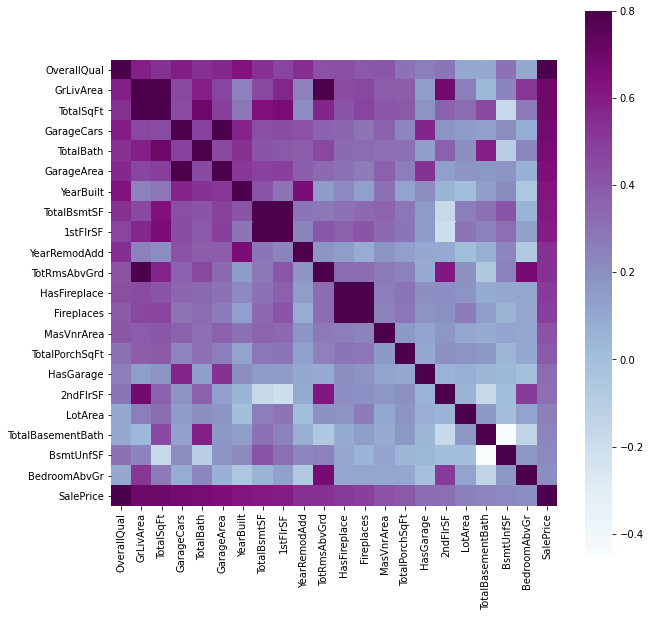

In [36]:
chosen_cols = num_features + cat_features
fig = plt.figure(figsize=(10, 10))
sns.heatmap(pd.concat([df_train[chosen_cols], y_train], axis=1).corr(),vmax=0.8, square=True,
            cmap='BuPu', annot_kws={'size': 14});

In [37]:
df_train = df_train[chosen_cols]
df_test = df_test[chosen_cols]
df_all = concat_df(df_train, df_test)
print("Data matched on choosen columns")

Data matched on choosen columns


### Feature Transformation

In [38]:
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.75]
print("Skewed features:")
print(skew_features)          
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

Skewed features:
LotArea           12.822431
MasVnrArea         2.613592
TotalSqFt          1.835745
1stFlrSF           1.469604
TotalPorchSqFt     1.376649
GrLivArea          1.269358
TotalBsmtSF        1.162616
BsmtUnfSF          0.919703
2ndFlrSF           0.861675
TotRmsAbvGrd       0.758367
HasGarage         -3.955907
dtype: float64


In [39]:
df_train, df_test = divide_df(df_all)
print("Data splitted")

Data splitted


#### Encode Categorical features

In [40]:
encoded_features = list()
for df in [df_train, df_test]:
    for feature in cat_features:
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cat_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cat_features):]], axis=1)

In [41]:
print("Final shape of data after encoding:")
print(df_train.shape, df_test.shape)

Final shape of data after encoding:
(1460, 223) (1459, 223)


In [42]:
df_train.drop(cat_features, axis=1, inplace=True)
df_test.drop(cat_features, axis=1, inplace=True)
print("Features dropped in train and test")
df_all = concat_df(df_train, df_test)

Features dropped in train and test


In [43]:
print("Final shape of data after dropping:")
print(df_train.shape, df_test.shape)

Final shape of data after dropping:
(1460, 196) (1459, 196)


In [44]:
x_train,x_val,y_train,y_val = train_test_split(df_train,y_train, test_size=0.2, random_state=42)

### Modeling

In [45]:
model_name = []
model_result = []
run_time = []

kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

def rmse(y, y_pred):
    """Function to calculate rmse"""
    return np.sqrt(mean_squared_error(y, y_pred))

def evaluate_model_cv(model, X, y):
    """Function to get rmse for the training data"""
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


### Baseline Model - Linear Regression

In [46]:
lr = LinearRegression()
start = time.perf_counter()
lr_model = lr.fit(np.array(x_train), np.array(y_train))
rmse_result = rmse(y_val, lr_model.predict(np.array(x_val)))
run_rmse = time.perf_counter() - start
print(f"RMSE for Linear Regression: ",rmse_result)
model_name.append("Linear Regression")
model_result.append(rmse_result)
run_time.append(run_rmse)


RMSE for Linear Regression:  0.1440073408822533


### Gradient Boost Regressor

In [47]:
gbr = GradientBoostingRegressor()
start = time.perf_counter()
gbr_model = gbr.fit(np.array(x_train), np.array(y_train))
rmse_result_gbr = rmse(y_val, gbr_model.predict(np.array(x_val)))
print(f"RMSE for gradient boost regressor score without optimization: ",rmse_result_gbr)
run_gbr = time.perf_counter() - start
model_name.append("GBR-no optimization")
model_result.append(rmse_result_gbr)
run_time.append(run_gbr)

RMSE for gradient boost regressor score without optimization:  0.14084343954977166


In [48]:
search_grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[42]}
search = GridSearchCV(estimator=gbr,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=kfolds)
search.fit(x_train,y_train)
search.best_score_

In [49]:
gbr_ = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=2000, random_state=42, subsample=0.5)
start = time.perf_counter()
pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", gbr_)   
                ])
pipe.fit(np.array(x_train), np.array(y_train))
rmse_result_gbr2 = rmse(y_val, pipe.predict(np.array(x_val)))
run_gbr2 = time.perf_counter() - start
model_name.append("GBR with optimization")
model_result.append(rmse_result_gbr2)
run_time.append(run_gbr2)
print(f"rmse for gradient boost regressor score with optimization: ",rmse_result_gbr2)

rmse for gradient boost regressor score with optimization:  0.13358724965030644


Submission score on test set with gradient boost is: `0.13073`

### Xtreme Gradient Boost

In [50]:
xgb= XGBRegressor(objective='reg:squarederror')
start = time.perf_counter()
xgb_model = xgb.fit(np.array(x_train), np.array(y_train))
xgb_rmse_result = rmse(y_val, xgb_model.predict(np.array(x_val)))
run_xgb = time.perf_counter() - start
model_name.append("XGB - no optimization")
model_result.append(xgb_rmse_result)
run_time.append(run_xgb)
print(f"rmse for xgb regressor score without optimization: ",xgb_rmse_result)


rmse for xgb regressor score without optimization:  0.14113450342724754


In [51]:
search_grid2 = {'n_estimators':[100,200,500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4,6,8],'subsample':[.5,.75,1],'random_state':[42]}
search2 = GridSearchCV(estimator=xgb,param_grid=search_grid2,scoring='neg_mean_squared_error',n_jobs=1,cv=kfolds)
search2.fit(x_train_scaled,y_train)
search2.best_score_

In [52]:
xgb = XGBRegressor(learning_rate=0.01, max_depth=4, n_estimators=2000, random_state=42, subsample=0.5,objective='reg:squarederror')
start = time.perf_counter()
pipe_xgb = Pipeline([
                ("scaler", StandardScaler()),
                ("model", xgb)   
                ])
pipe_xgb.fit(np.array(x_train), np.array(y_train))
rmse_result_xgb2 = rmse(y_val, pipe_xgb.predict(np.array(x_val)))
run_xgb2 = time.perf_counter() - start
model_name.append("XGB with optimization")
model_result.append(rmse_result_xgb2)
run_time.append(run_xgb2)
print(f"RMSE for gradient boost regressor score with optimization: ",rmse_result_xgb2)

RMSE for gradient boost regressor score with optimization:  0.13388230972788534


Submission score on test set with xtreme gradient boost is: `0.12999`

### Neural Network Regressor

In [53]:
X = df_train.copy()
y = y_train_copy
scaler = StandardScaler()
X_train = scaler.fit_transform(X.astype(np.float))

In [54]:
def create_model():
    """Create model"""
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               63040     
_________________________________________________________________
dense_1 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_2 (Dense)              (None, 352)               135520    
_________________________________________________________________
dense_3 (Dense)              (None, 448)               158144    
_________________________________________________________________
dense_4 (Dense)              (None, 160)               71840     
_________________________________________________________________
dense_5 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                5

In [55]:
model = create_model()
start = time.perf_counter()
history = model.fit(x=x_train,y=y_train,batch_size=128,epochs=170)
rmse_result_nn = rmse(y_val, model.predict(np.array(x_val)))
run_nn = time.perf_counter() - start
model_name.append("Neural Network")
model_result.append(rmse_result_nn)
run_time.append(run_nn)
print(f"RMSE for Neural Network: ",rmse_result_nn)

Epoch 1/170
10/10 [==============================] - 3s 5ms/step - loss: 38771.6484
Epoch 2/170
10/10 [==============================] - 0s 4ms/step - loss: 18.5679
Epoch 3/170
10/10 [==============================] - 0s 4ms/step - loss: 13.2289
Epoch 4/170
10/10 [==============================] - 0s 4ms/step - loss: 3.8345
Epoch 5/170
10/10 [==============================] - 0s 5ms/step - loss: 1.5905
Epoch 6/170
10/10 [==============================] - 0s 5ms/step - loss: 0.9299
Epoch 7/170
10/10 [==============================] - 0s 4ms/step - loss: 0.3653
Epoch 8/170
10/10 [==============================] - 0s 5ms/step - loss: 0.2421
Epoch 9/170
10/10 [==============================] - 0s 4ms/step - loss: 0.2508
Epoch 10/170
10/10 [==============================] - 0s 4ms/step - loss: 0.1825
Epoch 11/170
10/10 [==============================] - 0s 4ms/step - loss: 0.1557
Epoch 12/170
10/10 [==============================] - 0s 4ms/step - loss: 0.1442
Epoch 13/170
10/10 [===========

Best score on leaderboard for Neural Network is `0.21907`.
Keras doesn't seem to be a suitable model for this dataset because the data given is not sufficient.

In [58]:
X_test = df_test.copy()
X_test_scaled = scaler.transform(X_test)
sub = pd.read_csv("sample_submission.csv")
pred = np.exp(model.predict(X_test))
sub.SalePrice=pred
sub.to_csv("submission16.csv",index=False)

## Model Evaluation

In [57]:
result = pd.DataFrame(
    {
        "Model": model_name,
        "result": model_result,
        "runtime(seconds)": run_time
}
)
result.sort_values(by="result")

,Model,result,runtime(seconds)
2,GBR with optimization,0.133587,9.450339
4,XGB with optimization,0.133882,15.291346
1,GBR-no optimization,0.140843,0.679887
3,XGB - no optimization,0.141135,1.303556
0,Linear Regression,0.144007,0.041636
5,Neural Network,0.222359,12.282450


## Conclusion

The shortest runtime was achieved with Simple Linear Regression while Gradient Boost Regressor with hyperparameter tuning performed optimally in terms of validation score. 

The Xtreme Gradient Boost achieved the best score of `0.12999` on the leaderboard.

Neural Network performed worse both on the validation test and also on the leaderboard. This can be attributed to insufficient data.